# NOAA Dataset: Significant Wave Height Prediction
In oceanography and maritime engineering, accurately predicting the height of significant waves is important. It has major impacts on the safety of coastal infrastructure, the generation of renewable energy, and the planning of operations at sea. The usual way to deal with this problem is to use weather data like wind speed, air pressure, and temperature, based on the idea that these outside forces are the main things that affect the sea state. This project is making a predictive model like this one using a high-frequency dataset from a NOAA buoy.

However, a first look at the dataset shows that there is a basic conflict between two different, competing predictive signals. So, the main goal of this work is to make a good model by figuring out how these two signals affect each other:

- **Autoregressive Signal:** This comes from inside the system itself. Significant wave height has a lot of autocorrelation, which means that the value at any given time is very much affected by its value in the recent past. This makes a strong but possibly misleading signal that suggests a simple "persistence" model could work very well.

- **Meteorological Signal:** The second signal comes from outside and shows the physical drivers that need to be modeled. The main idea behind any physics-based model is that changes in weather variables like wind speed, atmospheric pressure, and others hold the key to predicting how the sea state will change, no matter what it was like before.

Two things about the dataset that are built in make this project even harder because they have a significant effect on these signals. First, the wave height data is very quantized, which means that it is reported in separate steps instead of as a continuous variable. This makes the autoregressive signal seem "stickier" than it really is, which in turn makes the sea state seem more stable than it really is and could hide small changes. Second, the data only covers a month, which may not be enough time to see all the different types of weather that are needed to find a strong, generalizable link between meteorological forces and wave height.

## Setup and Data Loading

### Dependencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import optuna
import os
import random

from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from vmdpy import VMD
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

sns.set_theme(style="whitegrid")

### Data Loading

In [3]:
file_path = "../data/clean/NOAA_complete.csv"

df_complete = pd.read_csv(file_path, index_col=0, parse_dates=True)
df_complete.sort_index(inplace=True)

df_complete.head()

,latitude_degrees_north,longitude_degrees_east,air_temperature_celsius,sea_level_pressure_hpa,gust_speed_mps,significant_wave_height_m,dominant_wave_period_s,sea_surface_temperature_celsius,wind_speed,buoy2_wind_speed,buoy3_wave_height
2013-04-18 01:00:00+00:00,47.348999,-124.708,7.2,1032.599976,8.0,1.0,8.0,10.1,5.0,5.2,1.1
2013-04-18 01:20:00+00:00,47.348999,-124.708,7.2,1032.599976,8.0,1.0,8.0,10.1,5.0,5.3,1.3
2013-04-18 01:40:00+00:00,47.348999,-124.708,7.2,1032.599976,8.0,1.0,8.0,10.1,5.0,5.4,1.2
2013-04-18 02:00:00+00:00,47.348999,-124.708,6.8,1032.300049,5.0,1.1,6.0,10.0,4.0,5.2,1.2
2013-04-18 02:20:00+00:00,47.348999,-124.708,6.8,1032.300049,5.0,1.1,6.0,10.0,4.0,5.4,1.0


### Configuration

In [4]:
# --- Time Series Settings ---

N_SPLITS = 5   # For Time-Series Cross-Validation
DATA_INTERVAL_MINUTES = 60
FORECAST_HORIZON_HOURS = 6

# --- VMD Parameters ---

VMD_ALPHA = 2000  # Bandwidth constraint
VMD_TAU = 0.      # Denoising term
VMD_K = 10        # Number of modes
VMD_DC = 0        # No DC part
VMD_INIT = 1      # Initialize omegas uniformly
VMD_TOL = 1e-7    # Tolerance

# --- LSTM Parameters ---

LSTM_N_PAST = 24   # Number of past time steps to use for prediction
LSTM_N_FUTURE = 6  # Number of future time steps to predict
LSTM_EPOCHS = 100
LSTM_BATCH_SIZE = 32

### Helper Functions

In [5]:
def set_seeds(seed=42):
    """Sets random seeds for reproducibility."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

In [6]:
def prepare_data_for_model(X, y, forecast_horizon_hours, data_interval_minutes):
    shift_periods = int(forecast_horizon_hours * 60 / data_interval_minutes)

    y_future = y.shift(-shift_periods)
    y_diff_h = y_future - y

    temp_df = X.copy()
    temp_df["target_diff"] = y_diff_h
    temp_df["y_current"] = y
    temp_df["y_actual_future"] = y_future
    temp_df.dropna(inplace=True)

    X_aligned = temp_df.drop(columns=["target_diff", "y_current", "y_actual_future"])
    y_h_diff = temp_df["target_diff"]
    y_h_current = temp_df["y_current"]
    y_h_actual = temp_df["y_actual_future"]

    return X_aligned, y_h_diff, y_h_current, y_h_actual

In [7]:
def evaluate_model(model, X_aligned, y_h_diff, y_h_current, y_h_actual, n_splits):    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores, r2_scores, mae_scores = [], [], []

    print(f"Evaluating {model.__class__.__name__} with {n_splits}-Fold Time-Series Cross-Validation...")

    for fold, (train_index, val_index) in enumerate(tscv.split(X_aligned)):
        X_train, X_val = X_aligned.iloc[train_index], X_aligned.iloc[val_index]
        y_train_diff, y_val_diff = y_h_diff.iloc[train_index], y_h_diff.iloc[val_index]
        y_val_current = y_h_current.iloc[val_index]
        y_val_actual = y_h_actual.iloc[val_index]

        if isinstance(model, xgb.XGBRegressor):
            model.fit(X_train, y_train_diff, eval_set=[(X_val, y_val_diff)], verbose=False)
        else:
            model.fit(X_train, y_train_diff)

        predicted_diffs = model.predict(X_val)
        preds_reconstructed = y_val_current + predicted_diffs

        rmse = np.sqrt(mean_squared_error(y_val_actual, preds_reconstructed))
        r2 = r2_score(y_val_actual, preds_reconstructed)
        mae = mean_absolute_error(y_val_actual, preds_reconstructed)

        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mae_scores.append(mae)

        print(f"  Fold {fold + 1}/{n_splits} - R²: {r2:.3f}, RMSE: {rmse:.3f} m, MAE: {mae:.3f} m")

    print("\nAverage Performance:")
    print(f"  Average R-squared (R²): {np.mean(r2_scores):.3f} (Std: {np.std(r2_scores):.3f})")
    print(f"  Average Root Mean Squared Error (RMSE): {np.mean(rmse_scores):.3f} m")
    print(f"  Average Mean Absolute Error (MAE): {np.mean(mae_scores):.3f} m")

In [8]:
def calculate_horizon_performance(model, model_name, X, y, n_splits):
    horizons_in_hours = range(1, 25)
    horizon_performance = {}
    
    for h in horizons_in_hours:
        X_h, y_h_diff, y_h_current, y_h_actual = prepare_data_for_model(X, y, h, DATA_INTERVAL_MINUTES)
        
        fold_scores = []
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        for train_index, val_index in tscv.split(X_h):
            X_train, X_val = X_h.iloc[train_index], X_h.iloc[val_index]
            y_train_diff, y_val_diff = y_h_diff.iloc[train_index], y_h_diff.iloc[val_index]
            y_val_current = y_h_current.iloc[val_index]
            y_val_actual = y_h_actual.iloc[val_index]
            
            if isinstance(model, xgb.XGBRegressor):
                model.fit(X_train, y_train_diff, eval_set=[(X_val, y_val_diff)], verbose=False)
            else:
                model.fit(X_train, y_train_diff)
            
            predicted_diffs = model.predict(X_val)
            reconstructed_preds = y_val_current + predicted_diffs
            score = r2_score(y_val_actual, reconstructed_preds)
            fold_scores.append(score)
            
        horizon_performance[h] = np.mean(fold_scores)
        
    return pd.Series(horizon_performance, name=model_name)

In [9]:
def plot_horizon_performance(*all_results):
    comparison_df = pd.concat(all_results, axis=1)
    
    plt.figure(figsize=(18, 8))
    sns.set_theme(style="whitegrid")
    
    for name, data in comparison_df.items():
        plt.plot(data.index, data, marker='o', linestyle='-', label=name)
        
    plt.axhline(y=0, color="r", linestyle=":", label="No Predictive Power (R²=0)")
    plt.title("Model Performance vs. Forecast Horizon", fontsize=18)
    plt.xlabel("Forecast Horizon (Hours)", fontsize=12)
    plt.ylabel("Average R-squared (R²)", fontsize=12)
    plt.xticks(range(1, 25))
    plt.legend(fontsize=12)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

In [10]:
def plot_residuals(model, X_base, y_base, horizons_to_plot, n_splits, data_interval_minutes):
    fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"{model.__class__.__name__}: Residuals Over Time (from Last CV Fold)", fontsize=20)
    
    for i, h_hours in enumerate(horizons_to_plot):
        ax = axes[i]
        
        X_h, y_h_diff, y_h_current, y_h_actual = prepare_data_for_model(X_base, y_base, h_hours, data_interval_minutes)
        tscv = TimeSeriesSplit(n_splits=n_splits)
        train_index, val_index = list(tscv.split(X_h))[-1]
        
        X_train, X_val = X_h.iloc[train_index], X_h.iloc[val_index]
        y_train_diff, y_val_diff = y_h_diff.iloc[train_index], y_h_diff.iloc[val_index]
        y_val_current = y_h_current.iloc[val_index]
        y_val_actual = y_h_actual.iloc[val_index]
        
        if isinstance(model, xgb.XGBRegressor):
            model.fit(X_train, y_train_diff, eval_set=[(X_val, y_val_diff)], verbose=False)
        else:
            model.fit(X_train, y_train_diff)
            
        predicted_diffs = model.predict(X_val)
        preds_reconstructed = y_val_current + predicted_diffs
        residuals = y_val_actual - preds_reconstructed
        
        residuals.plot(ax=ax, style='.', alpha=0.4, label='Residual')
        ax.axhline(0, color="red", linestyle="--")
        ax.set_title(f"{h_hours}-Hour Forecast Horizon", fontsize=14)
        ax.set_ylabel("Error (m)")
        ax.set_xlabel("Date")
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Feature Engineering

### Full Features

In [11]:
df_model = df_complete.sort_index().copy()

periods_per_hour = int(60 / DATA_INTERVAL_MINUTES)

# ==============================================================================
# --- 1. Foundational Persistence & Leading Indicator Lag Features ---
# ==============================================================================
# The most critical feature for capturing inertia (from PACF)
df_model["wave_height_lag_1p"] = df_model["significant_wave_height_m"].shift(1)

# Lag features for wind speed from the PRIMARY buoy (Buoy 1)
for lag_hr in [1, 3, 6]:
    lag_periods = lag_hr * periods_per_hour
    df_model[f"wind_speed_lag_{lag_hr}h"] = df_model["wind_speed"].shift(lag_periods)

# Lag features for wind speed from the FAST buoy (Buoy 2)
for lag_hr in [1, 3, 6]:
    lag_periods = lag_hr * periods_per_hour
    df_model[f"buoy2_wind_speed_lag_{lag_hr}h"] = df_model["buoy2_wind_speed"].shift(lag_periods)

# Lag features for pressure from the PRIMARY buoy
for lag_hr in [1, 3, 6]:
    lag_periods = lag_hr * periods_per_hour
    df_model[f"pressure_lag_{lag_hr}h"] = df_model["sea_level_pressure_hpa"].shift(lag_periods)

# ==============================================================================
# --- 2. Rolling Window Features to Capture Trends and Volatility ---
# ==============================================================================
for window_hr in [3, 6, 12]:
    window_periods = window_hr * periods_per_hour
    # Wind Features (Buoy 1)
    df_model[f"wind_speed_roll_mean_{window_hr}h"] = (df_model["wind_speed"].rolling(window=window_periods).mean())
    df_model[f"wind_speed_roll_max_{window_hr}h"] = (df_model["wind_speed"].rolling(window=window_periods).max())
    df_model[f"wind_speed_roll_std_{window_hr}h"] = (df_model["wind_speed"].rolling(window=window_periods).std())
    # Wind Features (Buoy 2)
    df_model[f"buoy2_wind_speed_roll_mean_{window_hr}h"] = (df_model["buoy2_wind_speed"].rolling(window=window_periods).mean())
    df_model[f"buoy2_wind_speed_roll_std_{window_hr}h"] = (df_model["buoy2_wind_speed"].rolling(window=window_periods).std())
    # Pressure Features (Buoy 1)
    df_model[f"pressure_roll_mean_{window_hr}h"] = (df_model["sea_level_pressure_hpa"].rolling(window=window_periods).mean())
    df_model[f"pressure_roll_std_{window_hr}h"] = (df_model["sea_level_pressure_hpa"].rolling(window=window_periods).std())

# ==============================================================================
# --- 3. Momentum & Acceleration Features to Model Change ---
# ==============================================================================
# Change in wave height (Buoy 1 - The Target's Station)
for diff_hr in [1, 3, 6]:
    diff_periods = diff_hr * periods_per_hour
    df_model[f"wave_height_momentum_{diff_hr}h"] = df_model["significant_wave_height_m"].diff(periods=diff_periods)

# Change in wind speed (Buoy 1)
for diff_hr in [1, 3, 6]:
    diff_periods = diff_hr * periods_per_hour
    df_model[f"wind_speed_momentum_{diff_hr}h"] = df_model["wind_speed"].diff(periods=diff_periods)

# Change in wind speed (Buoy 2)
for diff_hr in [1, 3, 6]:
    diff_periods = diff_hr * periods_per_hour
    df_model[f"buoy2_wind_speed_momentum_{diff_hr}h"] = df_model["buoy2_wind_speed"].diff(periods=diff_periods)

# Change in pressure (the pressure gradient)
for diff_hr in [1, 3, 6]:
    diff_periods = diff_hr * periods_per_hour
    df_model[f"pressure_gradient_{diff_hr}h"] = df_model["sea_level_pressure_hpa"].diff(periods=diff_periods)

# Anomaly Detection: How unusual is the current wind vs the last 12 hours
deviation_12h_periods = 12 * periods_per_hour
rolling_mean_12h = df_model["wind_speed"].rolling(window=deviation_12h_periods).mean()
rolling_std_12h = df_model["wind_speed"].rolling(window=deviation_12h_periods).std()
df_model["wind_deviation_12h"] = (df_model["wind_speed"] - rolling_mean_12h) / rolling_std_12h

# ==============================================================================
# --- 4. Cyclical and Time-Based Features ---
# ==============================================================================
df_model.index = pd.to_datetime(df_model.index)
df_model["hour_sin"] = np.sin(2 * np.pi * df_model.index.hour / 24)
df_model["hour_cos"] = np.cos(2 * np.pi * df_model.index.hour / 24)
df_model["day_of_year_sin"] = np.sin(2 * np.pi * df_model.index.dayofyear / 365.25)

# ==============================================================================
# --- 5. ENHANCED Interaction & Physics-Informed Features ---
# ==============================================================================
# Constants
rho_water = 1025
rho_air = 1.225
C_d = 0.0013
g = 9.81

# Wind stress and power from BOTH buoys
df_model["wind_stress"] = rho_air * C_d * df_model["wind_speed"] ** 2
df_model["wind_power"] = df_model["wind_speed"] ** 3
df_model["buoy2_wind_stress"] = rho_air * C_d * df_model["buoy2_wind_speed"] ** 2
df_model["buoy2_wind_power"] = df_model["buoy2_wind_speed"] ** 3

# Lagged wave energy
df_model["wave_energy_lagged"] = (0.125 * rho_water * g * df_model["wave_height_lag_1p"] ** 2)

# Pressure drop rate
df_model["pressure_drop_rate"] = df_model["sea_level_pressure_hpa"].diff(periods=1) * -1

# Spatial Gradient Features
df_model["spatial_wind_speed_diff"] = (df_model["wind_speed"] - df_model["buoy2_wind_speed"])
df_model["spatial_wave_height_diff"] = (df_model["significant_wave_height_m"] - df_model["buoy3_wave_height"])

# Max Wind Feature
df_model["max_wind_speed"] = df_model[["wind_speed", "buoy2_wind_speed"]].max(axis=1)

# Enhanced Storm Signal
df_model["storm_signal_interaction_enhanced"] = df_model["max_wind_speed"] * df_model["pressure_gradient_3h"].shift(3 * periods_per_hour)

# ==============================================================================
# --- 6. Final Cleanup ---
# ==============================================================================
df_model.dropna(inplace=True)

print("Shape of dataframe with enhanced features:", df_model.shape)
df_model.head()

Shape of dataframe with enhanced features: (2075, 68)


,latitude_degrees_north,longitude_degrees_east,air_temperature_celsius,sea_level_pressure_hpa,gust_speed_mps,significant_wave_height_m,dominant_wave_period_s,sea_surface_temperature_celsius,wind_speed,buoy2_wind_speed,...,wind_stress,wind_power,buoy2_wind_stress,buoy2_wind_power,wave_energy_lagged,pressure_drop_rate,spatial_wind_speed_diff,spatial_wave_height_diff,max_wind_speed,storm_signal_interaction_enhanced
2013-04-18 04:40:00+00:00,47.348999,-124.708,7.0,1031.699951,3.0,1.0,6.0,9.9,2.0,6.0,...,0.006370,8.0,0.057330,216.000000,1256.906250,-0.000000,-4.0,0.0,6.0,-3.000000
2013-04-18 05:00:00+00:00,47.348999,-124.708,7.1,1031.900024,2.0,0.9,8.0,9.9,1.0,5.8,...,0.001592,1.0,0.053572,195.112019,1256.906250,-0.200073,-4.8,-0.1,5.8,-0.580568
2013-04-18 05:20:00+00:00,47.348999,-124.708,7.1,1031.900024,2.0,0.9,8.0,9.9,1.0,5.7,...,0.001592,1.0,0.051740,185.192981,1018.094008,-0.000000,-4.7,-0.1,5.7,-0.570559
2013-04-18 05:40:00+00:00,47.348999,-124.708,7.1,1031.900024,2.0,0.9,8.0,9.9,1.0,5.1,...,0.001592,1.0,0.041421,132.650993,1018.094008,-0.000000,-4.1,-0.1,5.1,-0.510500
2013-04-18 06:00:00+00:00,47.348999,-124.708,7.2,1031.699951,1.0,0.9,6.0,9.8,0.0,5.1,...,0.000000,0.0,0.041421,132.650993,1018.094008,0.200073,-5.1,-0.1,5.1,1.020372


### Correlation of Full Features

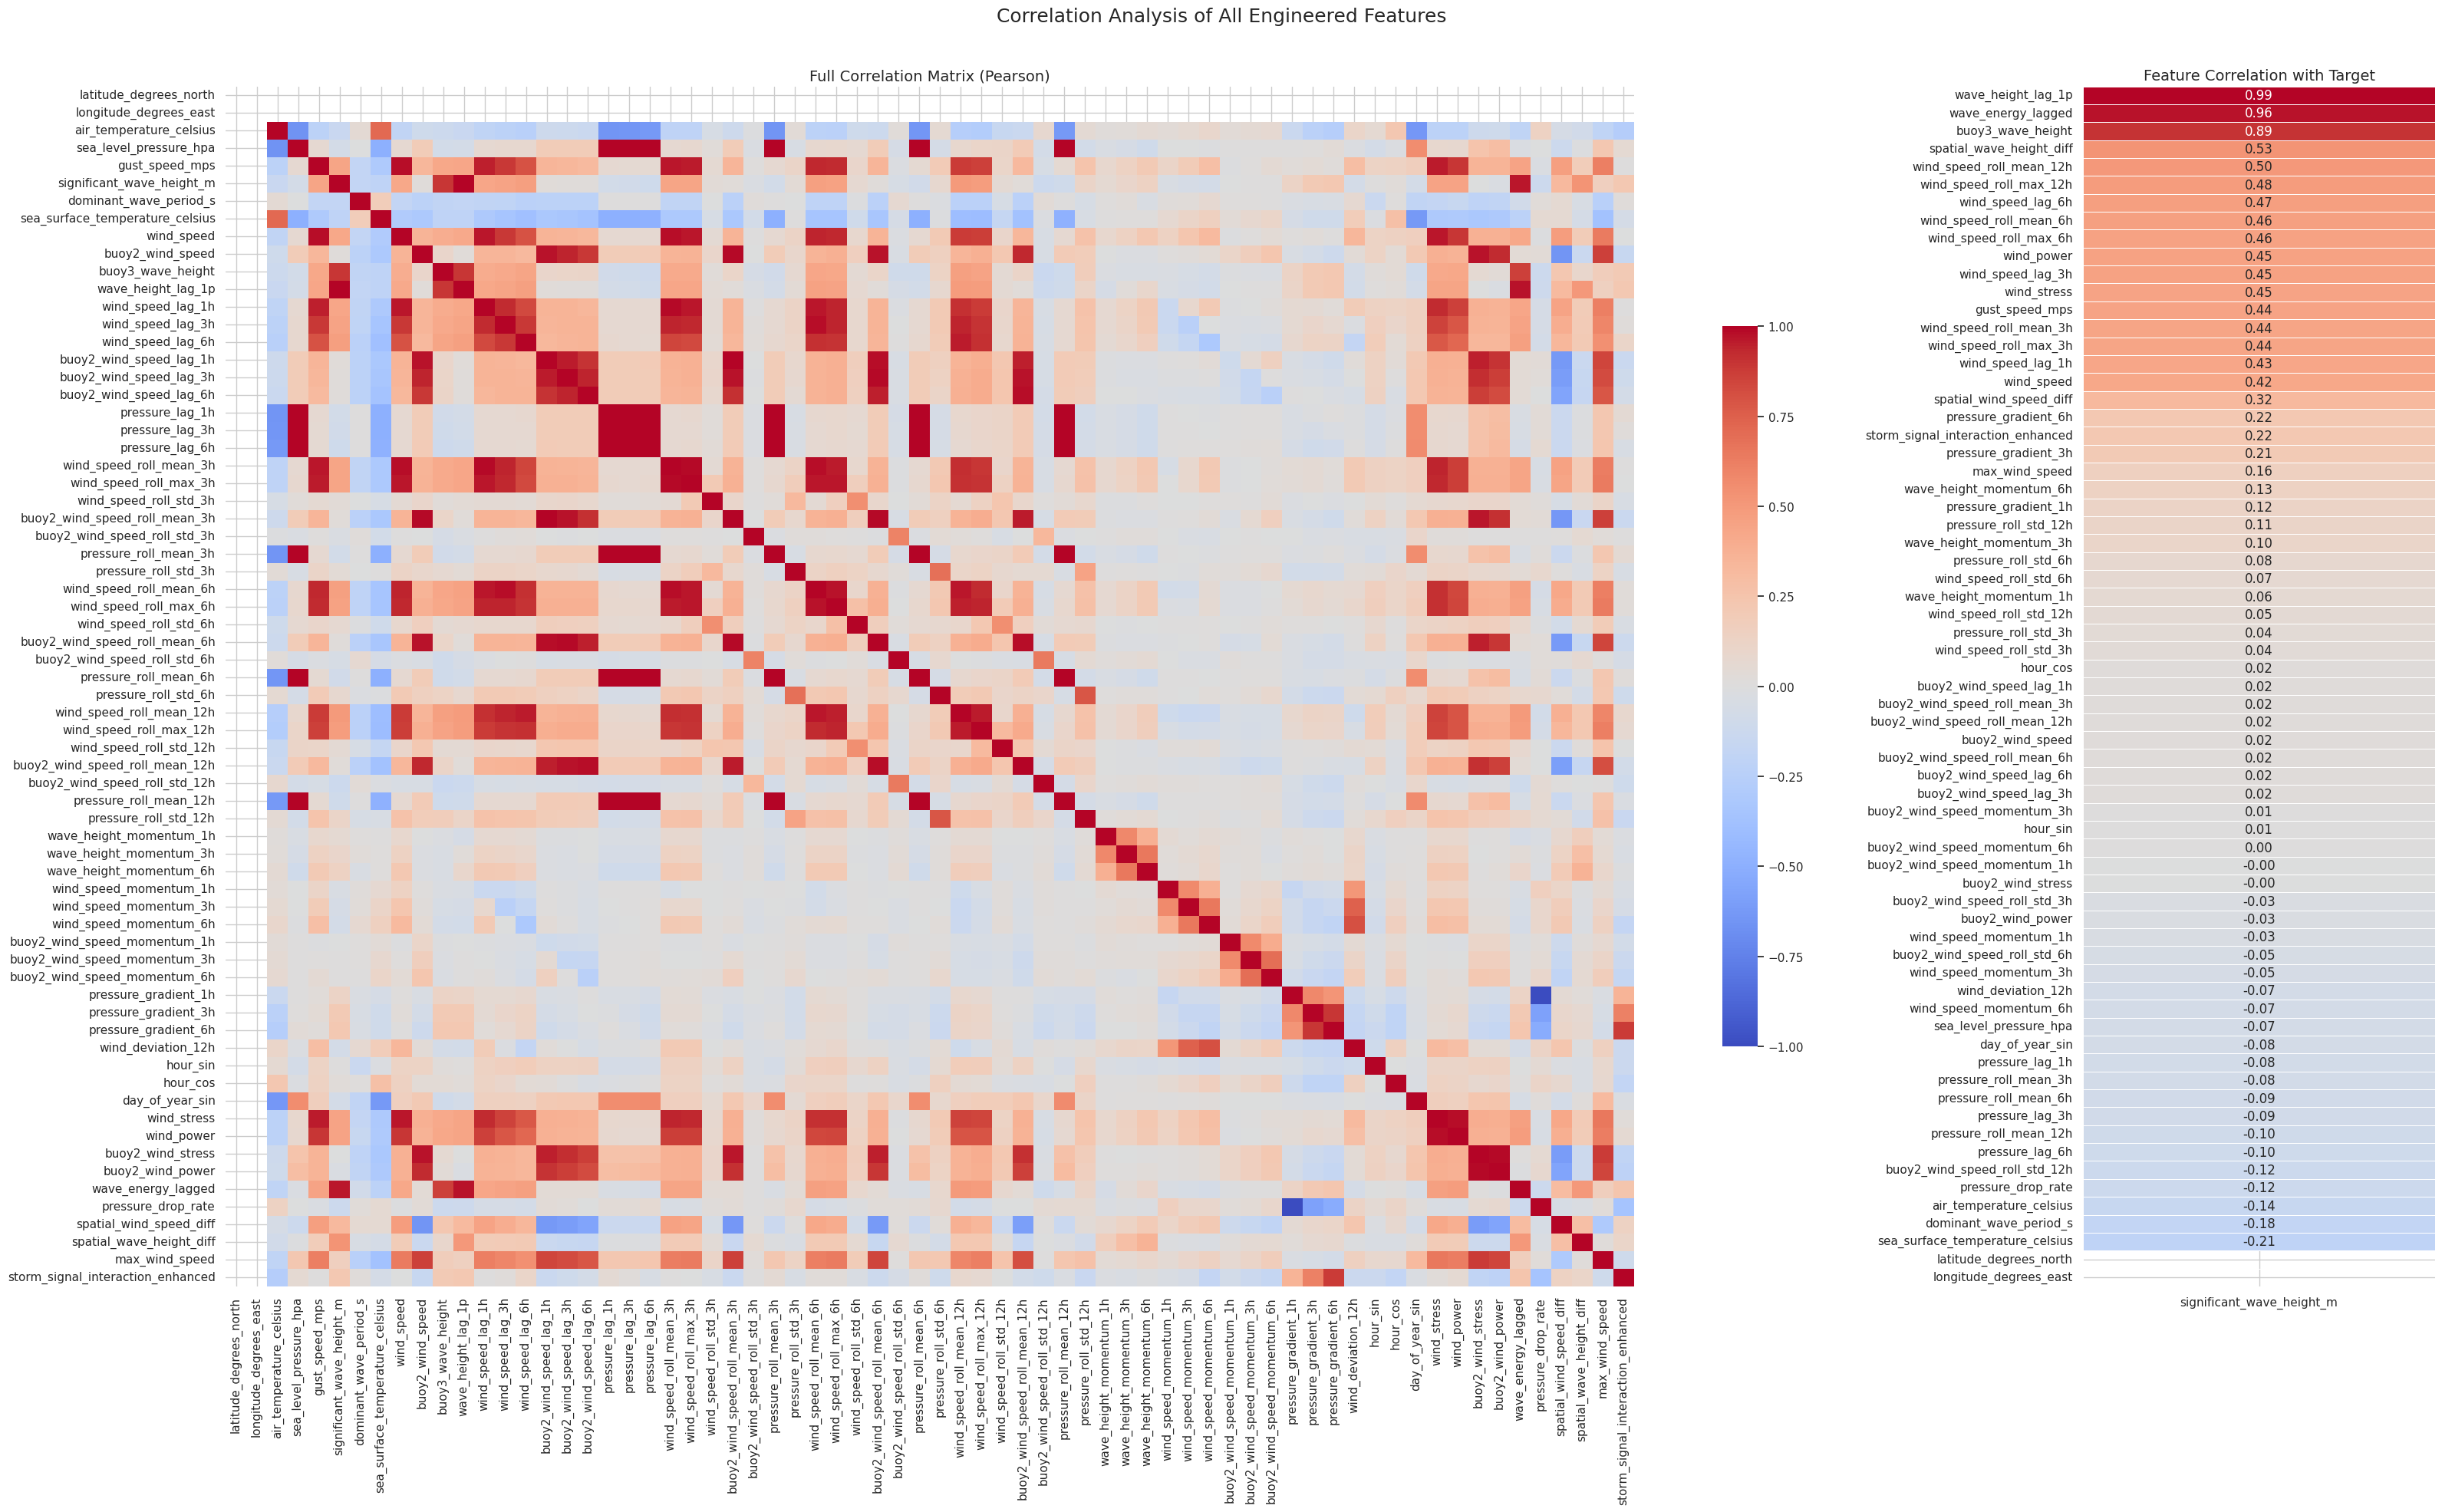

In [12]:
target_col = "significant_wave_height_m"

df_corr = df_model.copy()
corr_matrix = df_corr.corr(method="pearson")
corr_with_target = (
    corr_matrix[[target_col]]
    .drop(index=target_col)
    .sort_values(by=target_col, ascending=False)
)

fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(32, max(10, len(corr_with_target) * 0.3)),
    gridspec_kw={"width_ratios": [5, 1]},
)
fig.suptitle("Correlation Analysis of All Engineered Features", fontsize=18)

# Full Correlation Matrix Heatmap
sns.heatmap(
    corr_matrix,
    ax=ax1,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar_kws={"shrink": 0.6},
)
ax1.set_title("Full Correlation Matrix (Pearson)", fontsize=14)
ax1.tick_params(axis="x", rotation=90)
ax1.tick_params(axis="y", rotation=0)

# Feature Correlation with Target Heatmap
sns.heatmap(
    corr_with_target,
    ax=ax2,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
)
ax2.set_title("Feature Correlation with Target", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Feature Selection

In [13]:
target = "significant_wave_height_m"

# This list is made based on the above correlation matrix to select a powerful,
# non-redundant set of features. The goal is to pick the best from each
# conceptual group, including the new spatial and multi-buoy features.

features_to_use = [
    # 1. Persistence & Target Proxy
    "wave_height_lag_1p",           # The direct lagged value of the target.
    "buoy3_wave_height",            # The measurement from the nearby buoy which is a powerful proxy.
    
    # 2. Spatial & Interaction Features
    "spatial_wave_height_diff",          # The difference in wave height between buoys.
    "spatial_wind_speed_diff",           # The difference in wind between buoys.
    "storm_signal_interaction_enhanced", # Custom storm signal indicator using max wind speed.
    
    # 3. Wind & Weather Conditions
    "wind_speed_roll_mean_12h",     # Represents the long-term wind trend.
    "wind_speed_roll_std_3h",       # Represents recent wind volatility.
    "pressure_gradient_6h",         # The pressure *gradient* is more predictive than the level itself.
    "dominant_wave_period_s",       # Fundamental sea-state parameter.
    
    # 4. Momentum
    "wave_height_momentum_1h",      # The most recent rate of change of the target variable itself.
    
    # 5. Cyclical / Time-Based
    "hour_sin",                     # Captures diurnal effects.
    "hour_cos",
]

features_to_use = [f for f in features_to_use if f in df_model.columns]

X = df_model[features_to_use]
y = df_model[target]

print(f"Final shape of lean feature matrix X: {X.shape}")
print(f"Final shape of target vector y: {y.shape}")
print("\nSelected Features for Final Model:")
for f in X.columns:
    print(f"- {f}")

Final shape of lean feature matrix X: (2075, 12)
Final shape of target vector y: (2075,)

Selected Features for Final Model:
- wave_height_lag_1p
- buoy3_wave_height
- spatial_wave_height_diff
- spatial_wind_speed_diff
- storm_signal_interaction_enhanced
- wind_speed_roll_mean_12h
- wind_speed_roll_std_3h
- pressure_gradient_6h
- dominant_wave_period_s
- wave_height_momentum_1h
- hour_sin
- hour_cos


### Correlation of Selected Features

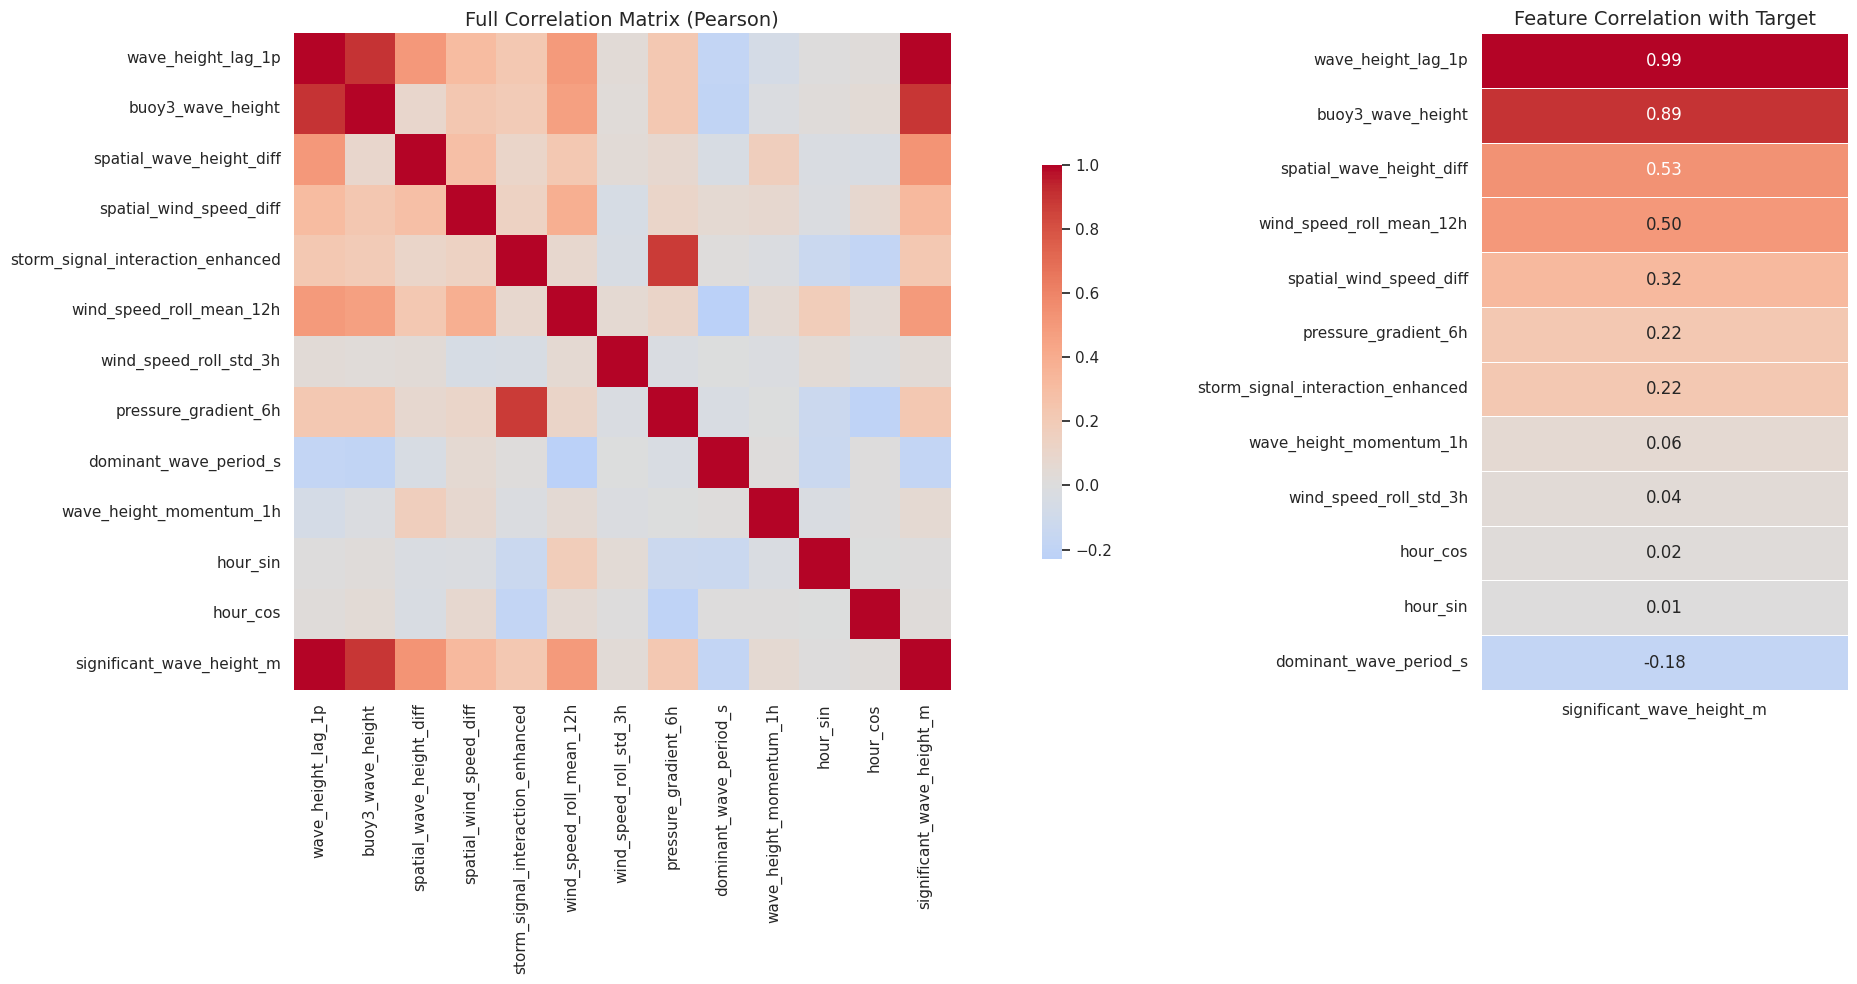

In [14]:
df_corr = X.copy()
df_corr[target] = y

# Pearson correlation matrix
corr_matrix = df_corr.corr(method="pearson")
corr_with_target = (
    corr_matrix[[target]].drop(index=target).sort_values(by=target, ascending=False)
)

fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(24, max(10, len(corr_with_target) * 0.2)),
    gridspec_kw={"width_ratios": [5, 1]},
)

# Full correlation matrix
sns.heatmap(
    corr_matrix,
    ax=ax1,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar_kws={"shrink": 0.6},
    square=True,
)
ax1.set_title("Full Correlation Matrix (Pearson)", fontsize=14)

# Target-only correlations
sns.heatmap(
    corr_with_target,
    ax=ax2,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
)
ax2.set_title("Feature Correlation with Target", fontsize=14)

plt.tight_layout()
plt.show()

## Model: Naive Persistence Model

In [15]:
class ZeroPredictor:
    """
    Mimics a scikit-learn regressor but always predicts zero.
    
    This is used to adapt the Naive Persistence model (which predicts a change of 0)
    to the evaluation functions that expect a model with .fit() and .predict() methods.
    """
    def fit(self, X, y):
        # The Naive model doesn't need to be trained, so we do nothing.
        pass
        
    def predict(self, X):
        # For any given set of features X, predict a difference of 0 for every sample.
        return np.zeros(len(X))
    
    # Add a class name property to make our plots look nice
    @property
    def __class__(self):
        class MockClassName:
            @property
            def __name__(self):
                return "Naive Persistence"
        return MockClassName()

### Time-Series Cross-Validation

In [16]:
naive_model = ZeroPredictor()
X_aligned, y_h_diff, y_h_current, y_h_actual = prepare_data_for_model(X, y, FORECAST_HORIZON_HOURS, DATA_INTERVAL_MINUTES)
evaluate_model(naive_model, X_aligned, y_h_diff, y_h_current, y_h_actual, N_SPLITS)

Evaluating Naive Persistence with 5-Fold Time-Series Cross-Validation...
  Fold 1/5 - R²: 0.827, RMSE: 0.121 m, MAE: 0.087 m
  Fold 2/5 - R²: 0.912, RMSE: 0.193 m, MAE: 0.137 m
  Fold 3/5 - R²: 0.747, RMSE: 0.126 m, MAE: 0.093 m
  Fold 4/5 - R²: 0.928, RMSE: 0.105 m, MAE: 0.068 m
  Fold 5/5 - R²: 0.801, RMSE: 0.131 m, MAE: 0.094 m

Average Performance:
  Average R-squared (R²): 0.843 (Std: 0.068)
  Average Root Mean Squared Error (RMSE): 0.135 m
  Average Mean Absolute Error (MAE): 0.096 m


### Residual Plots

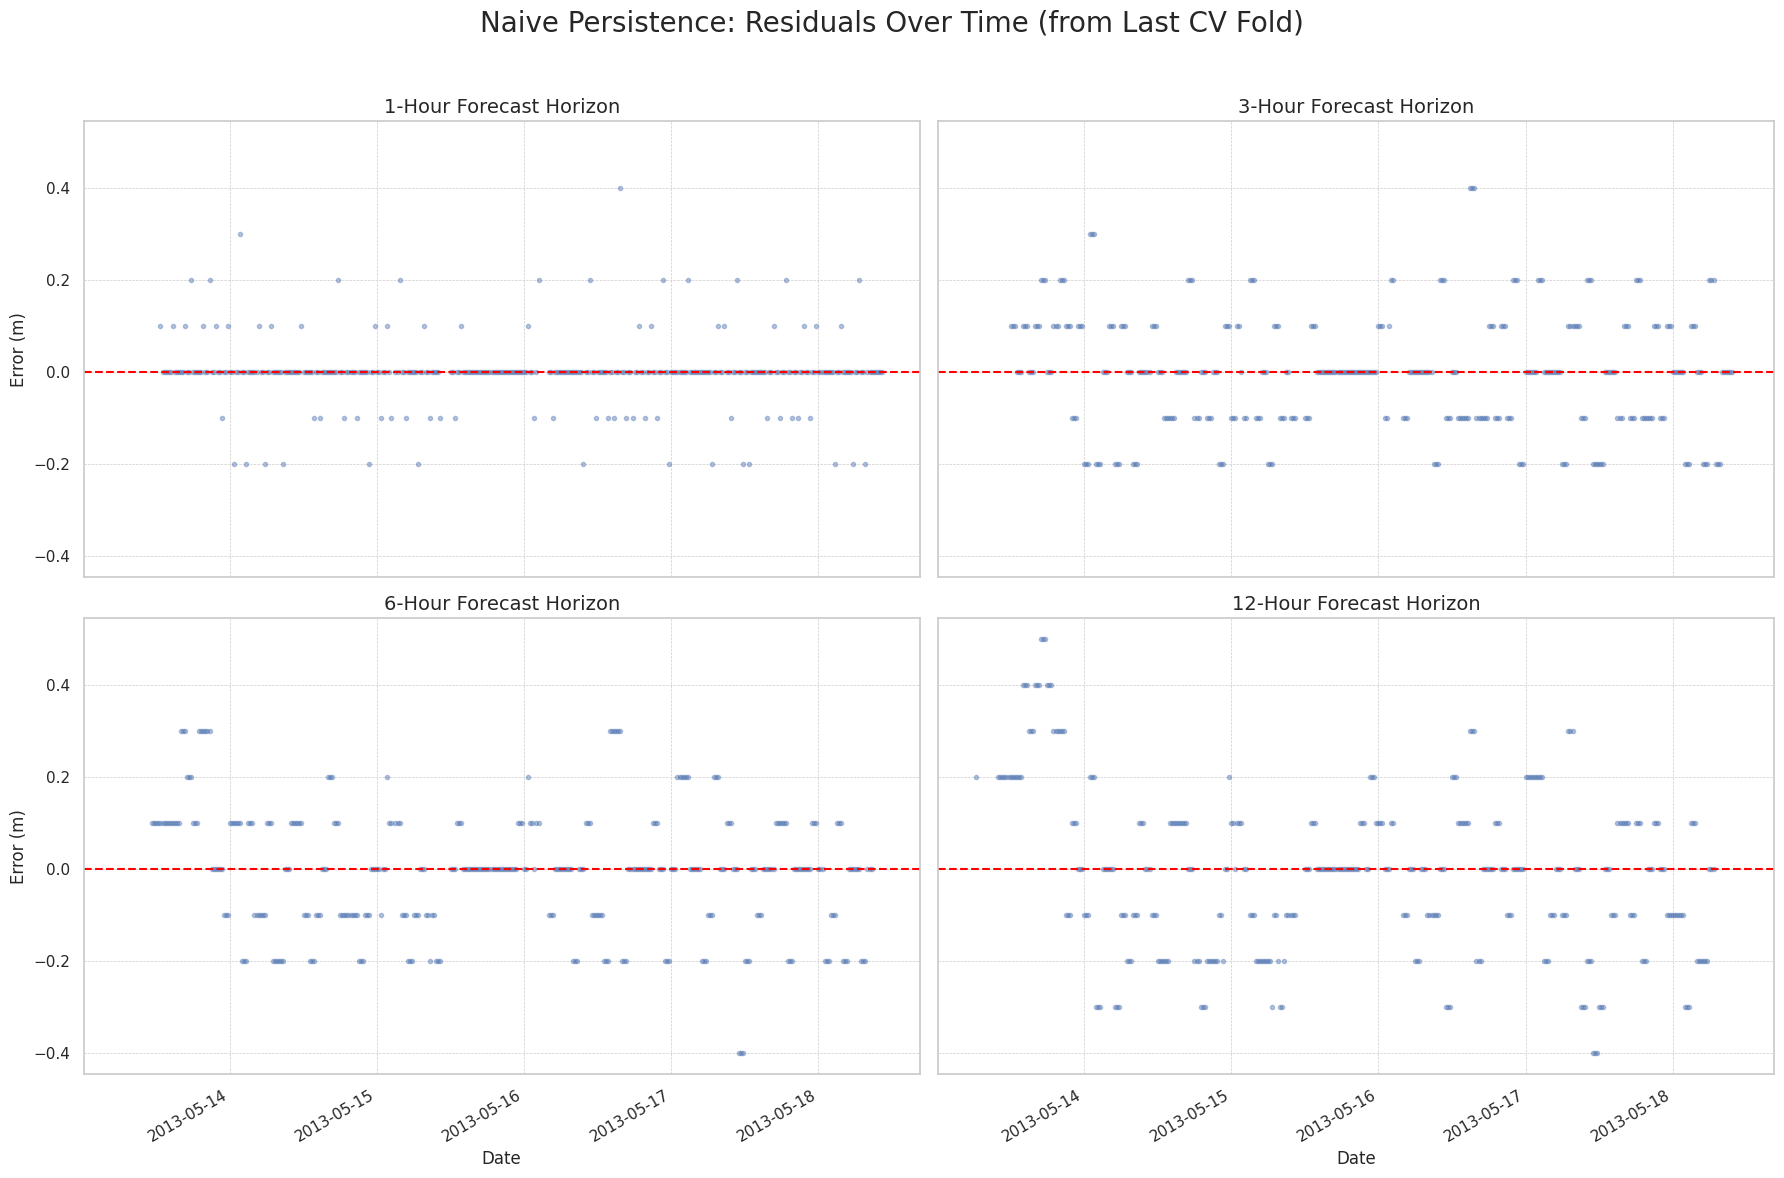

In [17]:
horizons_to_plot = [1, 3, 6, 12]
plot_residuals(ZeroPredictor(), X, y, horizons_to_plot, N_SPLITS, DATA_INTERVAL_MINUTES)

### Forecast Horizon Evaluation

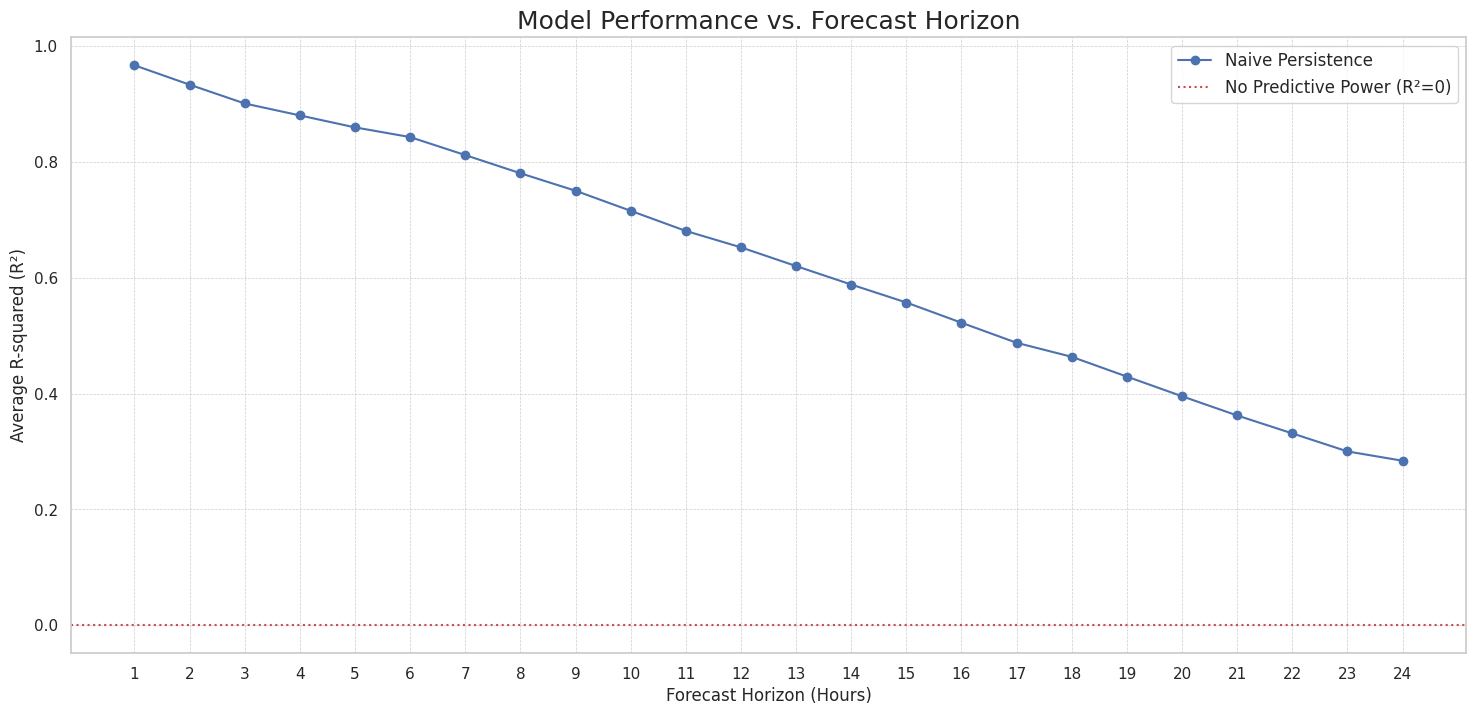

In [18]:
naive_results = calculate_horizon_performance(ZeroPredictor(), "Naive Persistence", X, y, N_SPLITS)
plot_horizon_performance(naive_results)

## Model: Ridge Regression

### Time-Series Cross-Validation

In [19]:
# Prepare data for the specified forecast horizon
X_aligned, y_h_diff, y_h_current, y_h_actual = prepare_data_for_model(X, y, FORECAST_HORIZON_HOURS, DATA_INTERVAL_MINUTES)

# Create a pipeline with a scaler and the RidgeCV model
rr_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-6, 6, 100), scoring="neg_mean_squared_error"))
])

# Evaluate the model using the helper function
evaluate_model(rr_pipeline, X_aligned, y_h_diff, y_h_current, y_h_actual, N_SPLITS)

Evaluating Pipeline with 5-Fold Time-Series Cross-Validation...
  Fold 1/5 - R²: 0.771, RMSE: 0.139 m, MAE: 0.111 m
  Fold 2/5 - R²: 0.917, RMSE: 0.187 m, MAE: 0.139 m
  Fold 3/5 - R²: 0.762, RMSE: 0.122 m, MAE: 0.094 m
  Fold 4/5 - R²: 0.923, RMSE: 0.108 m, MAE: 0.083 m
  Fold 5/5 - R²: 0.813, RMSE: 0.127 m, MAE: 0.097 m

Average Performance:
  Average R-squared (R²): 0.837 (Std: 0.070)
  Average Root Mean Squared Error (RMSE): 0.137 m
  Average Mean Absolute Error (MAE): 0.105 m


### Residual Plots

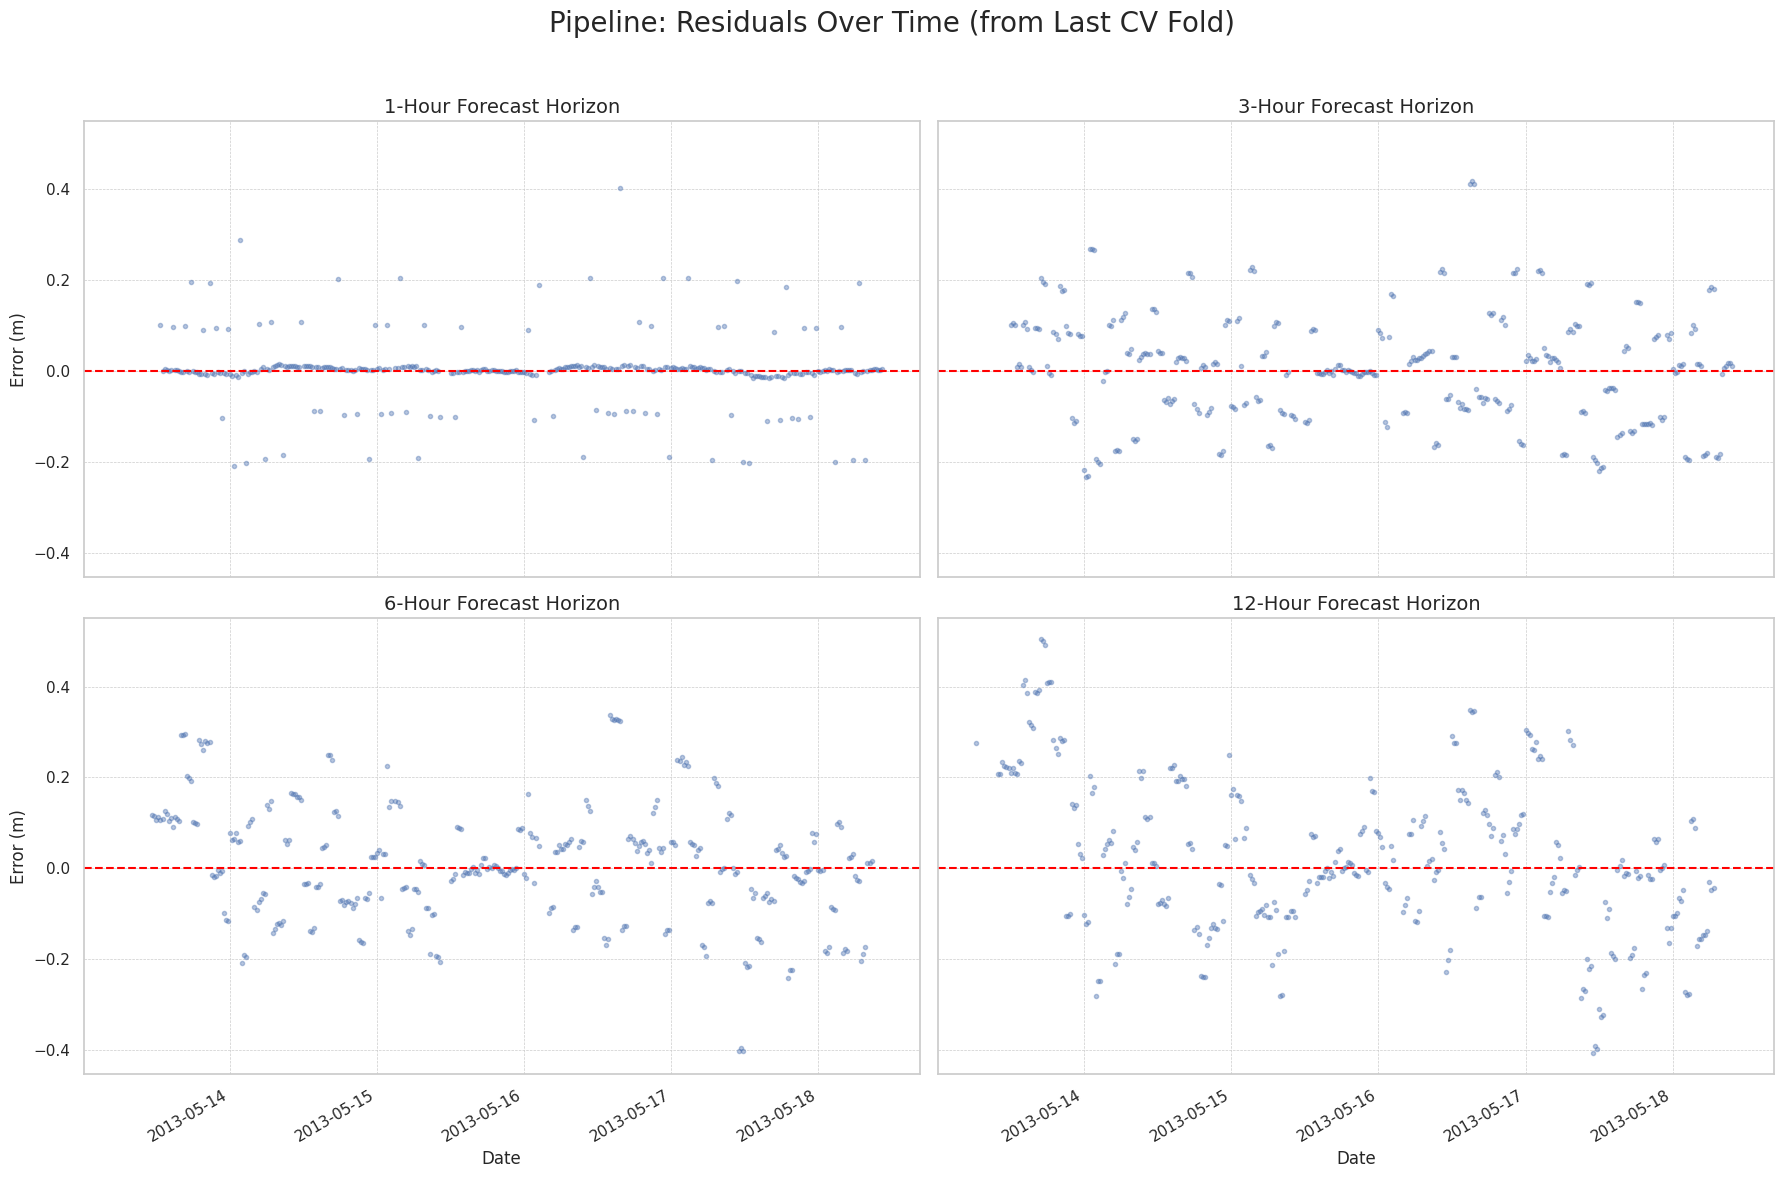

In [20]:
horizons_to_plot = [1, 3, 6, 12]
plot_residuals(rr_pipeline, X, y, horizons_to_plot, N_SPLITS, DATA_INTERVAL_MINUTES)

### Forecast Horizon Evaluation

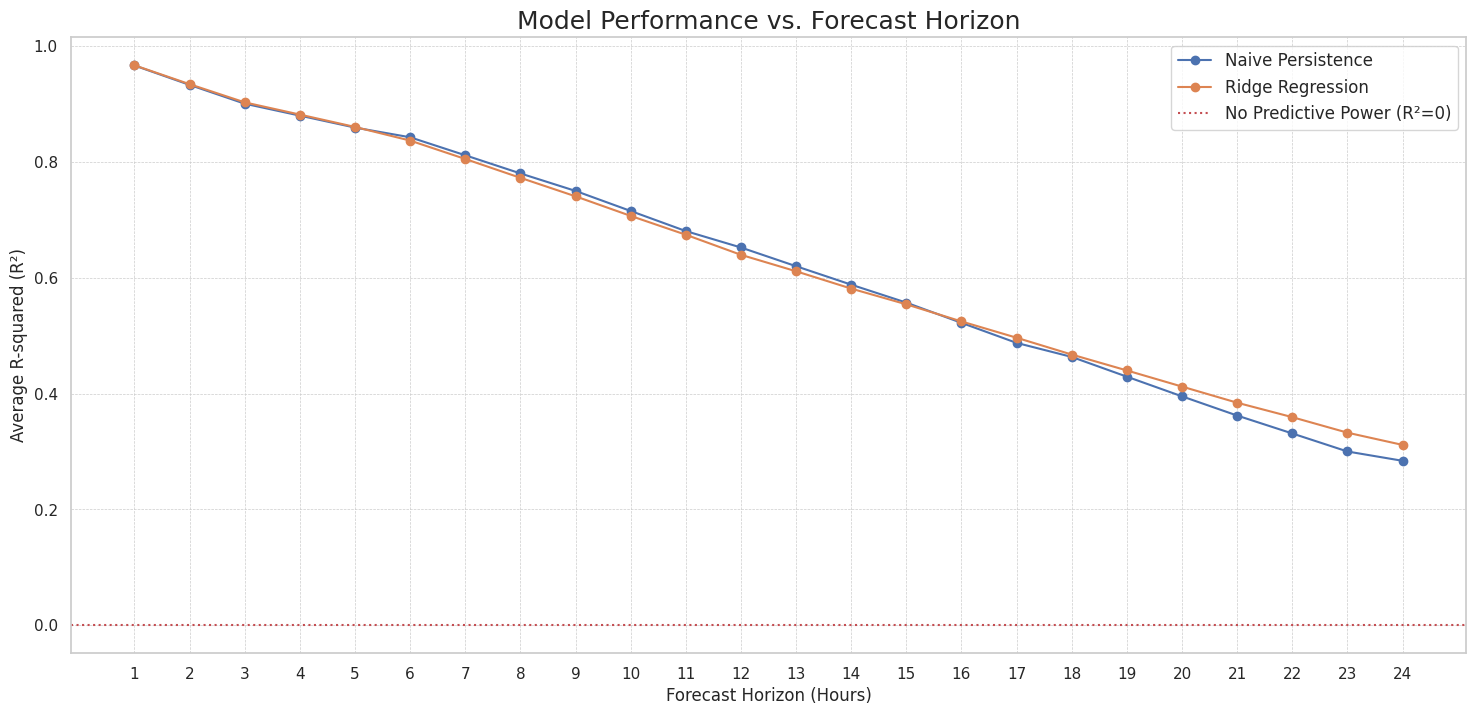

In [21]:
rr_results_diff = calculate_horizon_performance(rr_pipeline, "Ridge Regression", X, y, N_SPLITS)
plot_horizon_performance(naive_results, rr_results_diff)

## Model: Gradient Boosting

### Hyperparameter Tuning

In [22]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Prepare data for a long forecast horizon (24h) to find robust parameters
X_aligned_opt, y_h_diff_opt, y_h_current_opt, y_h_actual_opt = prepare_data_for_model(X, y, 24, DATA_INTERVAL_MINUTES)

def objective(trial):
    # Define the hyperparameter search space for Optuna
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1, 10),
        "alpha": trial.suggest_float("alpha", 0, 10),
        "early_stopping_rounds": 50,
        "n_jobs": -1,
    }

    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    rmse_scores = []

    # Evaluate the trial parameters using time series cross-validation
    for train_index, val_index in tscv.split(X_aligned_opt):
        X_train, X_val = X_aligned_opt.iloc[train_index], X_aligned_opt.iloc[val_index]
        y_train_diff, y_val_diff = y_h_diff_opt.iloc[train_index], y_h_diff_opt.iloc[val_index]
        y_val_current = y_h_current_opt.iloc[val_index]
        y_val_actual = y_h_actual_opt.iloc[val_index]

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train_diff, eval_set=[(X_val, y_val_diff)], verbose=False)

        predicted_diffs = model.predict(X_val)
        preds_reconstructed = y_val_current + predicted_diffs
        rmse = np.sqrt(mean_squared_error(y_val_actual, preds_reconstructed))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

print("Starting Hyperparameter Tuning for XGBoost...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

best_xgb_params = study.best_params
print("\nHyperparameter tuning complete!")
print(f"Best trial RMSE: {study.best_value:.4f}")
print("Best hyperparameters found:")
for key, value in best_xgb_params.items():
    print(f"  {key}: {value}")

Starting Hyperparameter Tuning for XGBoost...

Hyperparameter tuning complete!
Best trial RMSE: 0.2840
Best hyperparameters found:
  n_estimators: 791
  learning_rate: 0.1078523687217601
  max_depth: 3
  subsample: 0.7053630394698821
  colsample_bytree: 0.8862382978780614
  gamma: 0.034213743878303275
  lambda: 5.252741923448547
  alpha: 8.485712109594225


### Time-Series Cross-Validation

In [30]:
X_aligned, y_h_diff, y_h_current, y_h_actual = prepare_data_for_model(X, y, FORECAST_HORIZON_HOURS, DATA_INTERVAL_MINUTES)

final_xgb_params = best_xgb_params.copy()
final_xgb_params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "early_stopping_rounds": 50,
    "n_jobs": -1,
})
xgb_model = xgb.XGBRegressor(**final_xgb_params)

print(f"Running Sklearn Time-Series Cross-Validation for XGBoost ({FORECAST_HORIZON_HOURS}hr Horizon)...")
print("Using best parameters from Optuna tuning.")
evaluate_model(xgb_model, X_aligned, y_h_diff, y_h_current, y_h_actual, N_SPLITS)

Running Sklearn Time-Series Cross-Validation for XGBoost (6hr Horizon)...
Using best parameters from Optuna tuning.
Evaluating XGBRegressor with 5-Fold Time-Series Cross-Validation...
  Fold 1/5 - R²: 0.828, RMSE: 0.121 m, MAE: 0.088 m
  Fold 2/5 - R²: 0.911, RMSE: 0.193 m, MAE: 0.139 m
  Fold 3/5 - R²: 0.751, RMSE: 0.125 m, MAE: 0.094 m
  Fold 4/5 - R²: 0.931, RMSE: 0.102 m, MAE: 0.071 m
  Fold 5/5 - R²: 0.800, RMSE: 0.131 m, MAE: 0.095 m

Average Performance:
  Average R-squared (R²): 0.844 (Std: 0.068)
  Average Root Mean Squared Error (RMSE): 0.134 m
  Average Mean Absolute Error (MAE): 0.097 m


### Residual Plots

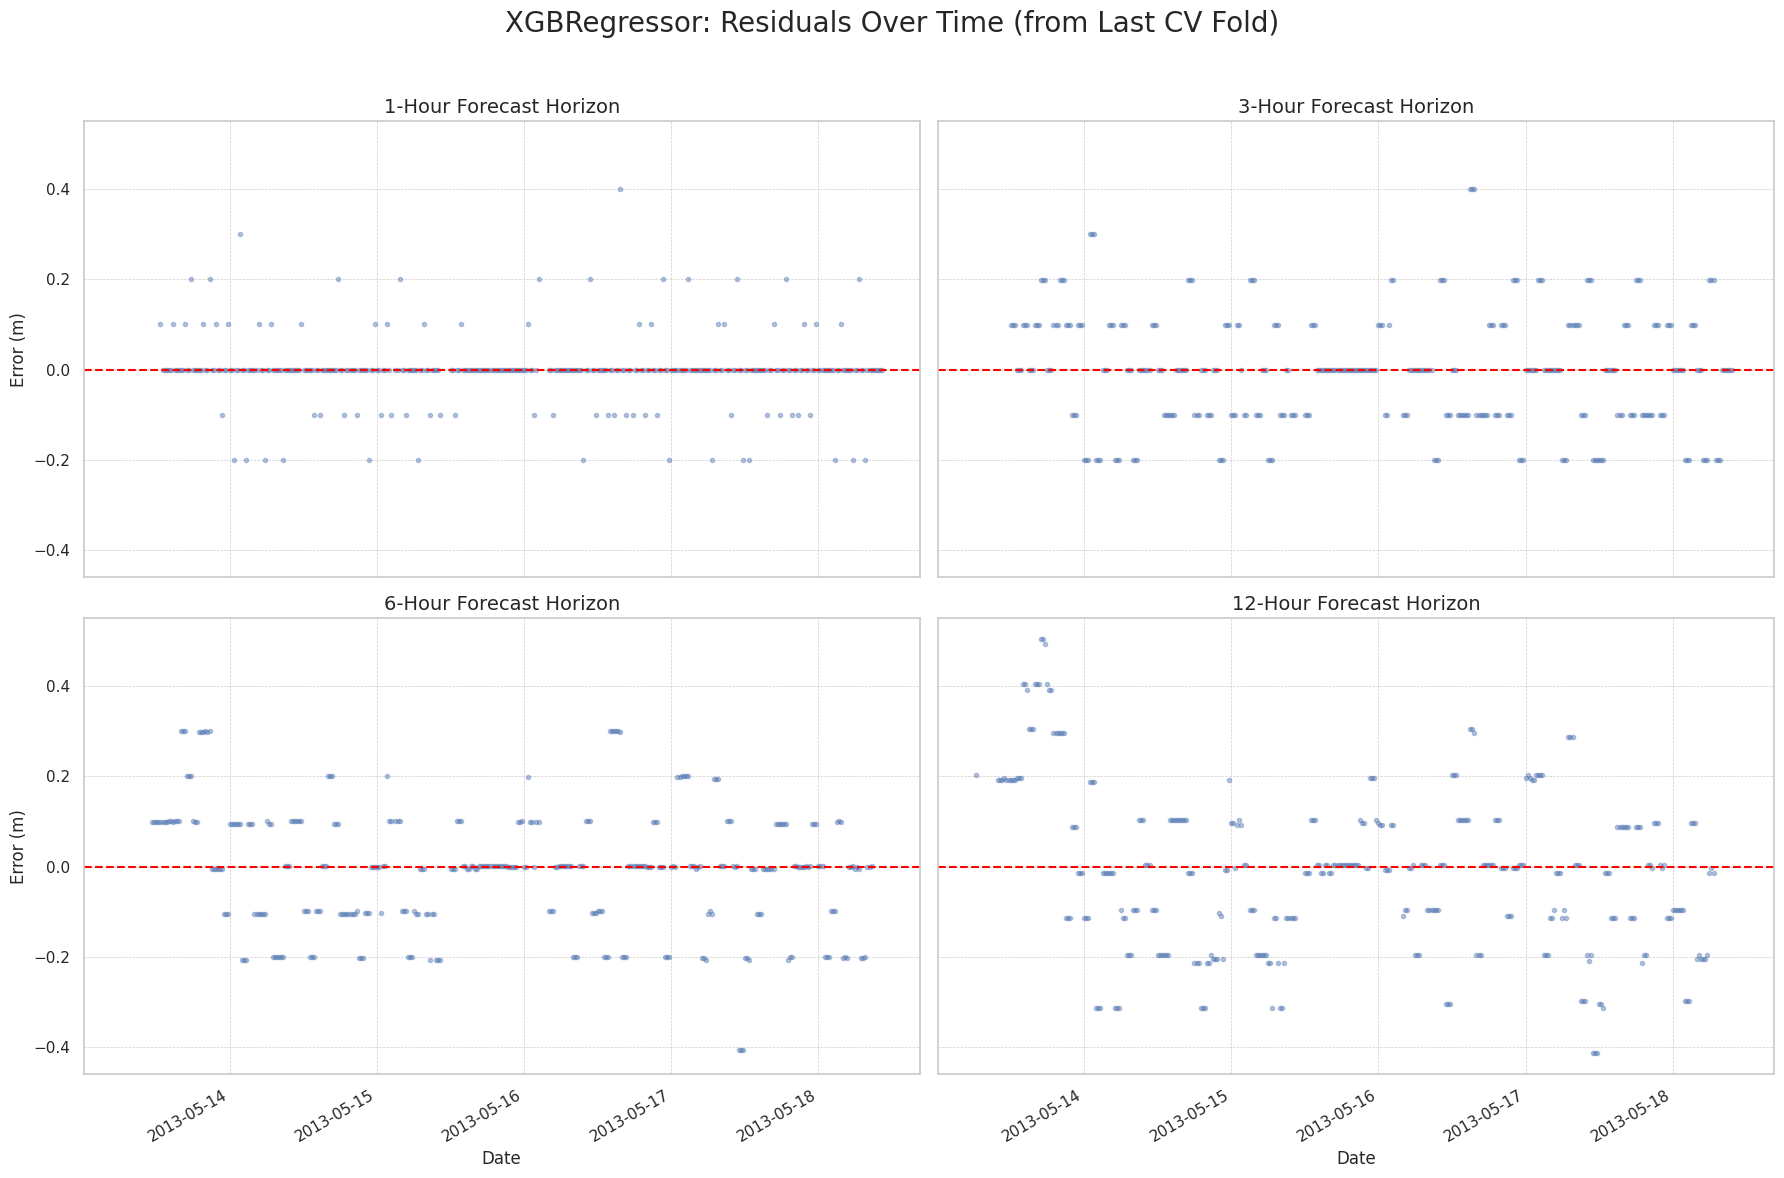

In [24]:
horizons_to_plot = [1, 3, 6, 12]
xgb_model_for_plot = xgb.XGBRegressor(**final_xgb_params)
plot_residuals(xgb_model_for_plot, X, y, horizons_to_plot, N_SPLITS, DATA_INTERVAL_MINUTES)

### Forecast Horizon Evaluation

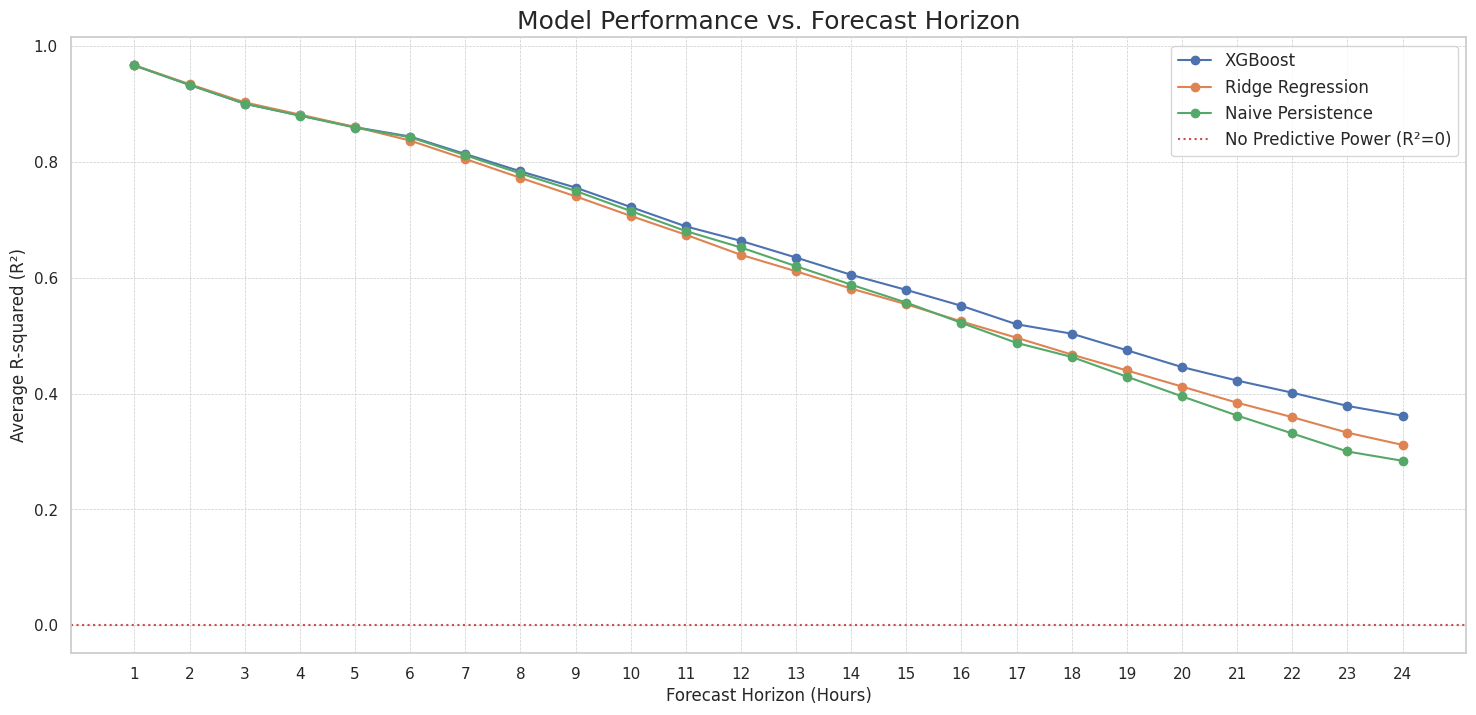

In [31]:
xgb_results_diff = calculate_horizon_performance(xgb_model, "XGBoost", X, y, N_SPLITS)
plot_horizon_performance(xgb_results_diff, rr_results_diff, naive_results)

## Model: VMD-LSTM

### VMD Decomposition

In [32]:
wave_height_signal = df_model['significant_wave_height_m'].dropna().values
imfs, imf_hat, omega = VMD(wave_height_signal, VMD_ALPHA, VMD_TAU, VMD_K, VMD_DC, VMD_INIT, VMD_TOL)
print(f"VMD complete. Signal decomposed into {imfs.shape[0]} modes (IMFs).")

# Store the IMFs in a DataFrame
imfs_df = pd.DataFrame(imfs.T, columns=[f'IMF_{i+1}' for i in range(VMD_K)])

VMD complete. Signal decomposed into 10 modes (IMFs).


### Data Preparation

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
imfs_scaled = scaler.fit_transform(imfs_df)

def create_sequences(data, n_past, n_future):
    """Creates sequences of past data (X) and future target values (y)."""
    X, y = [], []
    for i in range(len(data) - n_past - n_future + 1):
        X.append(data[i : i + n_past])
        y.append(data[i + n_past + n_future - 1, 0]) 
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(imfs_scaled, LSTM_N_PAST, LSTM_N_FUTURE)
print(f"Created sequences. X shape: {X_seq.shape}, y shape: {y_seq.shape}")

split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Created sequences. X shape: (2045, 24, 10), y shape: (2045,)
Train shapes: X=(1636, 24, 10), y=(1636,)
Test shapes: X=(409, 24, 10), y=(409,)


### Model Building

In [34]:
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,689 (479.25 KB)

 Trainable params: 122,689 (479.25 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, 
    y_train, 
    epochs=LSTM_EPOCHS, 
    batch_size=LSTM_BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1, 
    callbacks=[early_stopping]
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0883 - val_loss: 7.0234e-04
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0045 - val_loss: 6.6565e-04
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0032 - val_loss: 5.4415e-04
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0027 - val_loss: 7.6664e-04
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0027 - val_loss: 2.8714e-04
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0026 - val_loss: 7.5908e-04
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0021 - val_loss: 4.1654e-04
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0018 - val_loss: 5.9114e-04
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0024 - val_loss: 8.0903e-04
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0022 - val_loss: 7.9263e-04
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0017 - val_loss: 3.8482e-04
Epoch 12

### Model Evaluation

In [36]:
y_pred_scaled = model.predict(X_test)
dummy_pred = np.zeros((len(y_pred_scaled), VMD_K))
dummy_pred[:, 0] = y_pred_scaled.ravel()
y_pred_vmd = scaler.inverse_transform(dummy_pred)[:, 0]
dummy_test = np.zeros((len(y_test), VMD_K))
dummy_test[:, 0] = y_test.ravel()
y_true_vmd = scaler.inverse_transform(dummy_test)[:, 0]

rmse_vmd_lstm = np.sqrt(mean_squared_error(y_true_vmd, y_pred_vmd))
r2_vmd_lstm = r2_score(y_true_vmd, y_pred_vmd)
mae_vmd_lstm = mean_absolute_error(y_true_vmd, y_pred_vmd)

print(f"VMD-LSTM {LSTM_N_FUTURE}-Hour Forecast Performance:")
print(f" R-squared: {r2_vmd_lstm:.4f}")
print(f" RMSE (m): {rmse_vmd_lstm:.4f}")
print(f" MAE (m): {mae_vmd_lstm:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
VMD-LSTM 6-Hour Forecast Performance:
 R-squared: 0.9539
 RMSE (m): 0.0182
 MAE (m): 0.0142


### Model Performance

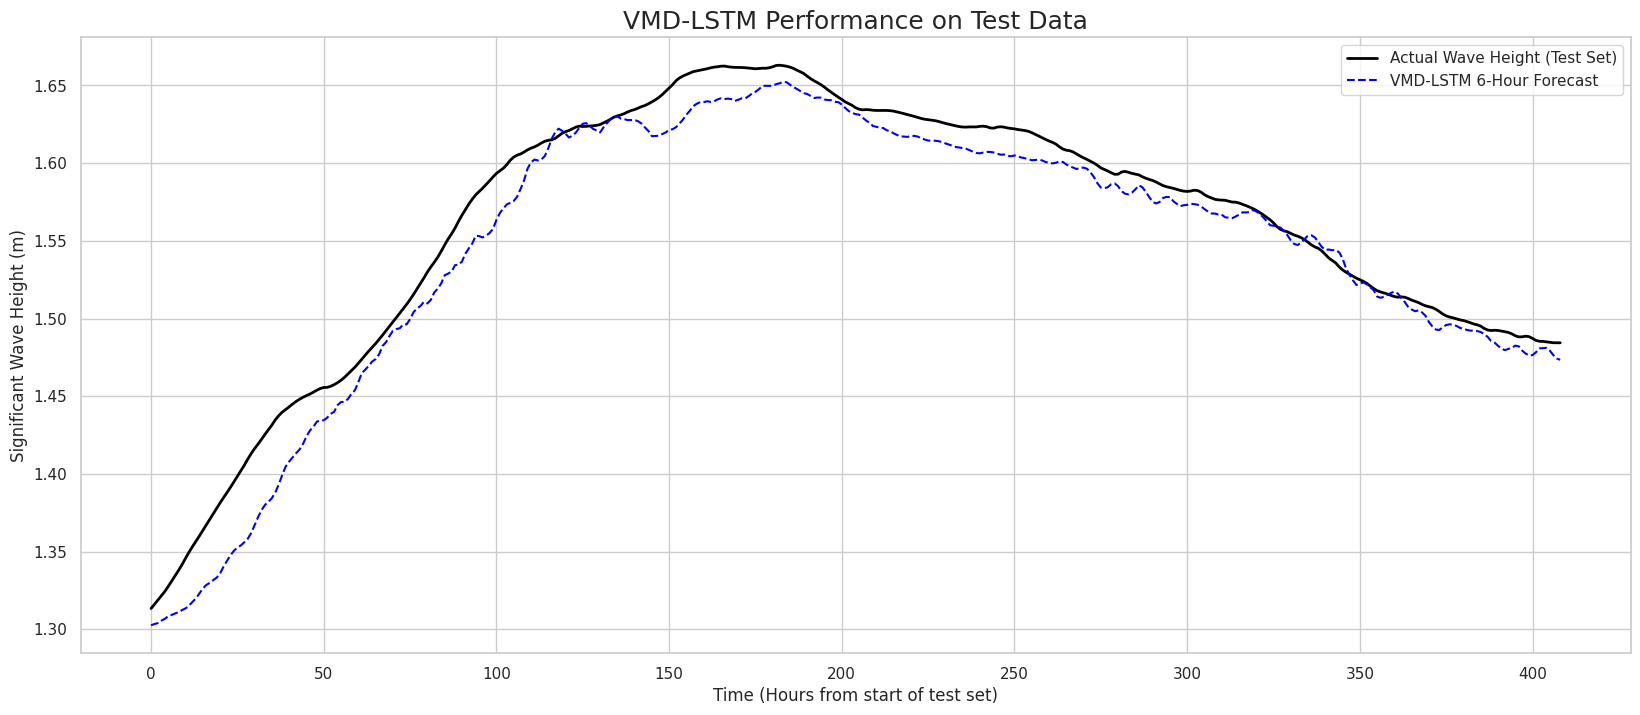

In [37]:
plt.figure(figsize=(20, 8))
plt.plot(y_true_vmd, label='Actual Wave Height (Test Set)', color='black', linewidth=2)
plt.plot(y_pred_vmd, label=f'VMD-LSTM {LSTM_N_FUTURE}-Hour Forecast', color='blue', linestyle='--')
plt.title('VMD-LSTM Performance on Test Data', fontsize=18)
plt.xlabel('Time (Hours from start of test set)')
plt.ylabel('Significant Wave Height (m)')
plt.legend()
plt.grid(True)
plt.show()

### Residual Plots

Starting VMD-LSTM Residual Plot Generation...
  Generating plot for horizon: 1 hour(s)...
  Generating plot for horizon: 3 hour(s)...
  Generating plot for horizon: 6 hour(s)...
  Generating plot for horizon: 12 hour(s)...


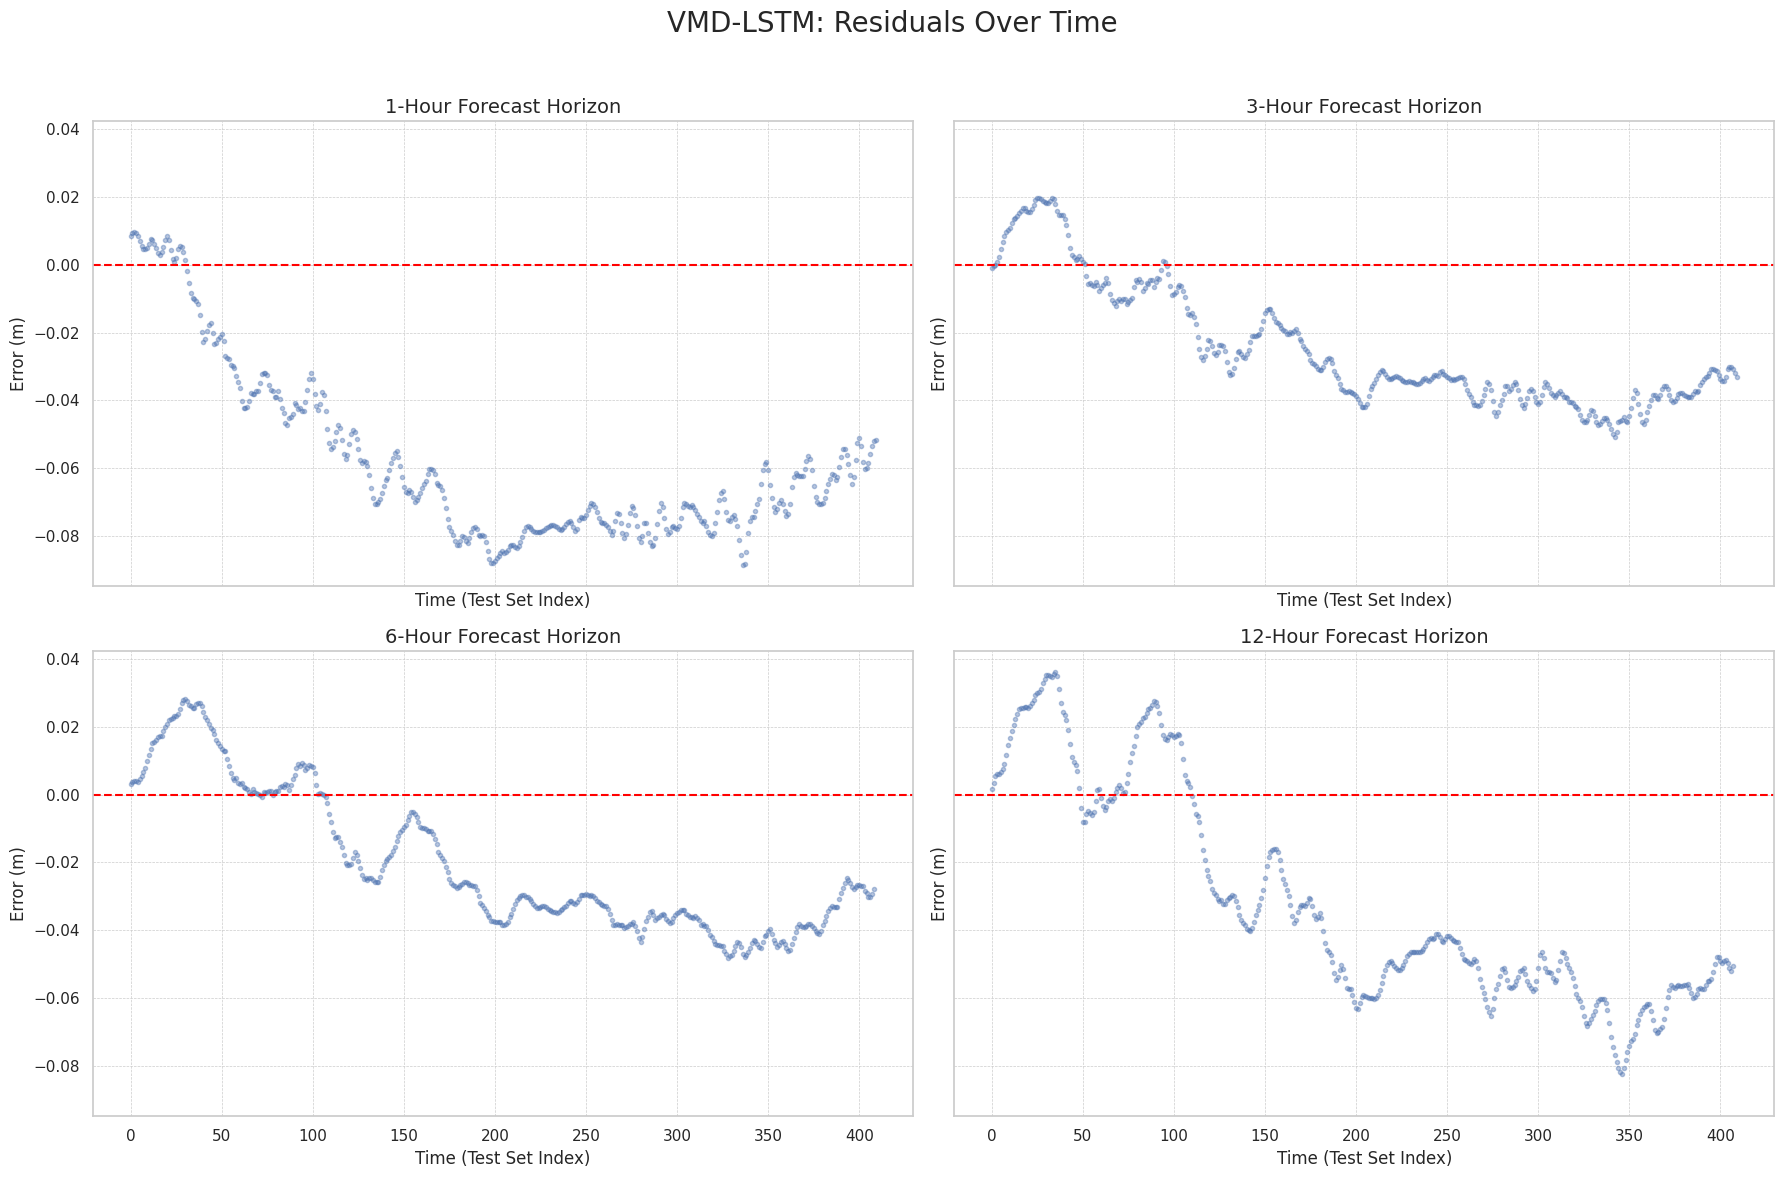

In [38]:
set_seeds(42)

horizons_to_plot_lstm = [1, 3, 6, 12]

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()
fig.suptitle("VMD-LSTM: Residuals Over Time", fontsize=20)

print("Starting VMD-LSTM Residual Plot Generation...")

for i, h_hours in enumerate(horizons_to_plot_lstm):
    print(f"  Generating plot for horizon: {h_hours} hour(s)...")
    ax = axes[i]
    
    # Logic to train and evaluate for the specific horizon
    X_seq_res, y_seq_res = create_sequences(imfs_scaled, LSTM_N_PAST, h_hours)
    split_idx_res = int(len(X_seq_res) * 0.8)
    X_train_res, X_test_res = X_seq_res[:split_idx_res], X_seq_res[split_idx_res:]
    y_train_res, y_test_res = y_seq_res[:split_idx_res], y_seq_res[split_idx_res:]

    if len(X_test_res) == 0:
        ax.text(0.5, 0.5, 'Not enough data', horizontalalignment='center')
        continue

    model_res = Sequential([
        tf.keras.Input(shape=(X_train_res.shape[1], X_train_res.shape[2])),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model_res.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping_res = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_res.fit(X_train_res, y_train_res, epochs=LSTM_EPOCHS, batch_size=LSTM_BATCH_SIZE, 
                  validation_split=0.1, verbose=0, callbacks=[early_stopping_res])
    
    y_pred_scaled_res = model_res.predict(X_test_res, verbose=0)
    dummy_pred_res = np.zeros((len(y_pred_scaled_res), VMD_K))
    dummy_pred_res[:, 0] = y_pred_scaled_res.ravel()
    y_pred_vmd_res = scaler.inverse_transform(dummy_pred_res)[:, 0]
    
    dummy_test_res = np.zeros((len(y_test_res), VMD_K))
    dummy_test_res[:, 0] = y_test_res.ravel()
    y_true_vmd_res = scaler.inverse_transform(dummy_test_res)[:, 0]
    
    residuals = y_true_vmd_res - y_pred_vmd_res
    ax.plot(residuals, '.', alpha=0.4)
    ax.axhline(0, color="red", linestyle="--")
    ax.set_title(f"{h_hours}-Hour Forecast Horizon", fontsize=14)
    ax.set_ylabel("Error (m)")
    ax.set_xlabel("Time (Test Set Index)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## References
[1] The COMET Program, University Corporation for Atmospheric Research. "Wave Types and Characteristics," [Online], MetEd. Accessed: July 27, 2025. [Online]. Available: [https://learn.meted.ucar.edu/](https://learn.meted.ucar.edu/#/online-courses/5f2b8dab-a47d-4111-a56b-74ec9f34a592).